# Part 1: Analyze the Network

## Introduction

This analysis examines a directed network of rock performers extracted from Wikipedia, where nodes represent bands or artists and directed edges indicate hyperlinks between their Wikipedia pages. The network contains 484 nodes and 7,323 directed edges. Each node has a `content_length` attribute indicating the character count of the corresponding Wikipedia page.

Using tools from Lecture 5, we characterize the network structure through visualization (using build in ForceAtlas2 method in `networkx` library), centrality measures (degree, betweenness, eigenvector), assortativity analysis, power-law distribution fitting, and network backbone extraction.

The directed nature of links in Wikipedia networks carries important semantic meaning. When band A links to band B, this connection reflects documented relationships such as shared tours, members, labels, or influences. However, the reverse link may not exist, creating asymmetry that distinguishes in-degree from out-degree. In-degree reflects prestige or fame, how many other pages mention a particular band. While out-degree reflects documentation scope of how comprehensively a band's own page documents related entities. This distinction is crucial because Wikipedia is opensource and edited by people, ith their own editorial choices, historical importance, and documentation practices.


## Data Setup

We load the rock band network from the pre-processed data file. The graph is a directed network where edges represent Wikipedia hyperlinks between artist pages. Isolated nodes have been removed, resulting in a single weakly connected component. We work with both the directed version (for in/out-degree analysis) and the undirected version (for centrality and other measures that require undirected graphs).


In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import requests
import io
from scipy import stats
import seaborn as sns

In [2]:
local_network = "../data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/rock_graph_node_link.json.gz"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")

# remove isolated nodes
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)

print(f"Loaded directed graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.")
print(f"Isolated nodes removed: {len(isolated_nodes)}")
print(f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}")

# making an undirected version
G_und = G_bands.to_undirected()
largest_cc = max(nx.connected_components(G_und), key=len)
G_gcc = G_und.subgraph(largest_cc).copy()

print(f"\nUndirected version: {G_und.number_of_nodes()} nodes and {G_und.number_of_edges()} edges")
print(f"Giant Connected Component: {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


Loaded directed graph with 484 nodes and 7323 edges.
Isolated nodes removed: 4
Graph component count: 1

Undirected version: 484 nodes and 6019 edges
Giant Connected Component: 484 nodes and 6019 edges


## Network Visualization with ForceAtlas2

Network visualization provides an intuitive representation of global structure that complements numerical measures. ForceAtlas2 just offers a more readable layout than traditional algorithms.

We visualize the network using NetworkX's built-in ForceAtlas2 layout algorithm as suggested in week5 lecture. In this plot, node size is proportional to degree, allowing prominent nodes with many connections to be easily seen, while node color represents the `content_length` attribute, roughly showing patterns in how bands are documented across the network.

In [3]:
pos_fa2 = nx.forceatlas2_layout(G_gcc, linlog=True, max_iter=500, seed=42)

/Users/rifo/miniforge3/envs/dtu02452/lib/python3.11/site-packages/networkx/drawing/layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


In [4]:
# prep node attributes for visualization
degrees_gcc = dict(G_gcc.degree())
node_sizes = [degrees_gcc[n] * 7 for n in G_gcc.nodes()]  #  scale to have better visual representation (we decided to go with 7)
content_lengths = [G_gcc.nodes[n].get("content_length", 0) for n in G_gcc.nodes()]

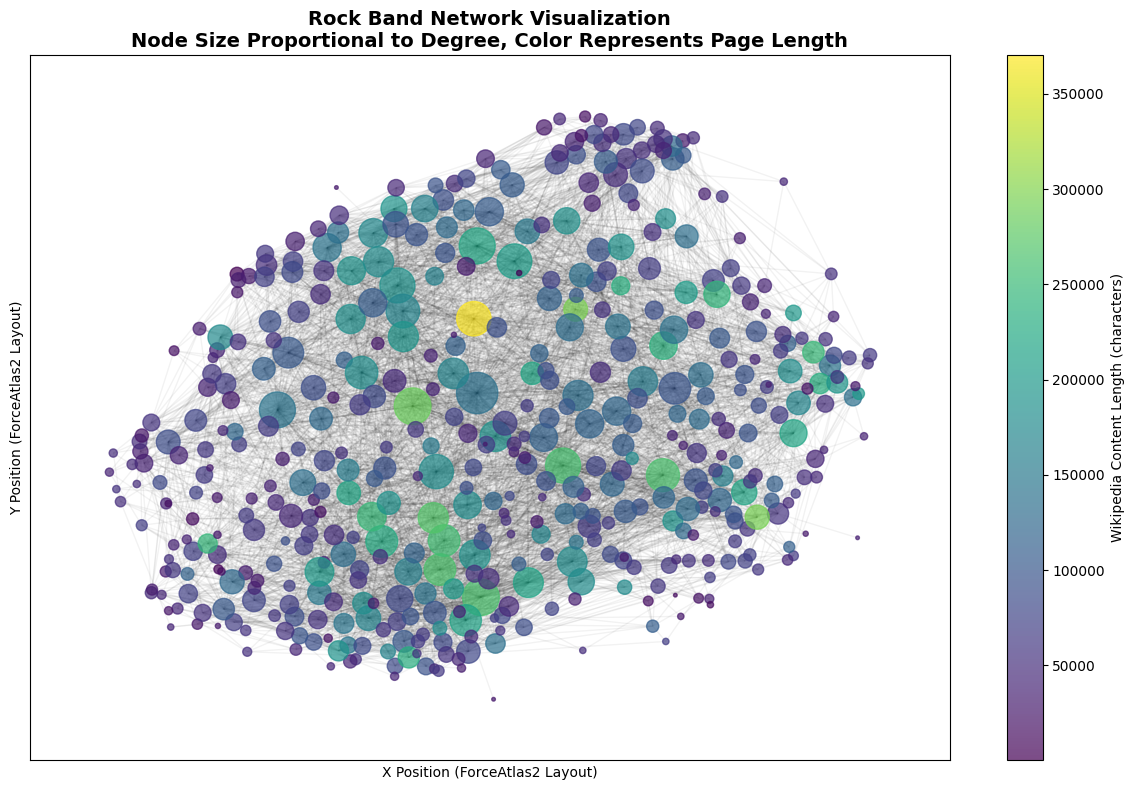

Visualization created with 484 nodes and 6019 edges


In [5]:
plt.figure(figsize=(12, 8))
nodes = nx.draw_networkx_nodes(
    G_gcc,
    pos_fa2,
    node_size=node_sizes,
    node_color=content_lengths,
    cmap=plt.cm.viridis,
    alpha=0.7
)
nx.draw_networkx_edges(G_gcc, pos_fa2, alpha=0.05, width=1, edge_color="black")

cbar = plt.colorbar(nodes, label="Wikipedia Content Length (characters)")
plt.xlabel("X Position (ForceAtlas2 Layout)")
plt.ylabel("Y Position (ForceAtlas2 Layout)")
plt.title(
    "Rock Band Network Visualization\nNode Size Proportional to Degree, Color Represents Page Length",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"Visualization created with {G_gcc.number_of_nodes()} nodes and {G_gcc.number_of_edges()} edges")


> **Figure 1** shows the network visualization using ForceAtlas2 layout. The spatial arrangement reveals clustering patterns and community structure, with larger nodes indicating bands that have more connections. The color gradient shows that bands with longer Wikipedia pages (warmer colors) are usually more connected in contrast with smaller and less connected pages, suggesting that documentation comprehensiveness and network position are related.


## Basic Network Structure

For directed networks such as Wikipedia, in-degree and out-degree must be analyzed separately because they capture different semantic meanings. In-degree reflects prestige or fame, how many other pages link to a particular band, indicating historical importance or influence. Out-degree reflects documentation scope, how comprehensively a band's own page documents related entities, which may be influenced by editorial practices and page comprehensiveness rather than historical importance alone.


In [6]:
# degree statistics for directed graph
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())
in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())


In [7]:
def calculate_mode(values):
    mode_result = stats.mode(values, keepdims=True)
    return mode_result.mode[0] if len(mode_result.mode) > 0 else None


In [8]:
print("In-Degree Statistics:")
print(f"  Mode:   {calculate_mode(in_deg_values)}")
print(f"  Min:    {np.min(in_deg_values)}")
print(f"  Max:    {np.max(in_deg_values)}")
print(f"  Std Dev: {np.std(in_deg_values):.2f}")

print("\nOut-Degree Statistics:")
print(f"  Mode:   {calculate_mode(out_deg_values)}")
print(f"  Min:    {np.min(out_deg_values)}")
print(f"  Max:    {np.max(out_deg_values)}")
print(f"  Std Dev: {np.std(out_deg_values):.2f}")

In-Degree Statistics:
  Mode:   3
  Min:    0
  Max:    119
  Std Dev: 17.00

Out-Degree Statistics:
  Mode:   12
  Min:    0
  Max:    74
  Std Dev: 10.63


To get a better understanding lets also look at correlation and degree distribution

In [9]:
# calculate correlation
correlation = np.corrcoef(out_deg_values, in_deg_values)[0, 1]

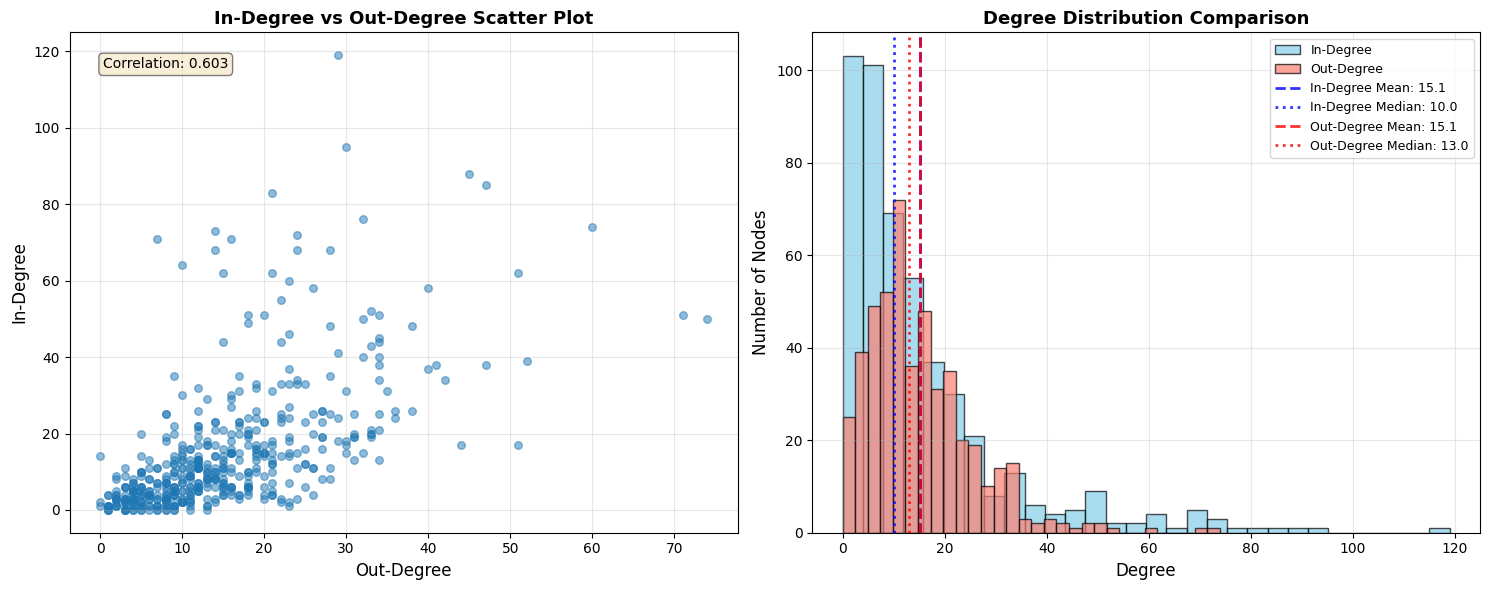

Correlation between in-degree and out-degree: 0.603


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# scatter plot
axes[0].scatter(out_deg_values, in_deg_values, alpha=0.5, s=30)
axes[0].set_xlabel("Out-Degree", fontsize=12)
axes[0].set_ylabel("In-Degree", fontsize=12)
axes[0].set_title("In-Degree vs Out-Degree Scatter Plot", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)

# correlation coefficient
axes[0].text(0.05, 0.95, f"Correlation: {correlation:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# histogram of degree distributions
axes[1].hist(in_deg_values, bins=30, alpha=0.7, label="In-Degree", color="skyblue", edgecolor="black")
axes[1].hist(out_deg_values, bins=30, alpha=0.7, label="Out-Degree", color="salmon", edgecolor="black")

# vertical lines for mean and median
in_mean = np.mean(in_deg_values)
in_median = np.median(in_deg_values)
out_mean = np.mean(out_deg_values)
out_median = np.median(out_deg_values)

axes[1].axvline(in_mean, color="blue", linestyle="--", linewidth=2, label=f"In-Degree Mean: {in_mean:.1f}", alpha=0.8)
axes[1].axvline(in_median, color="blue", linestyle=":", linewidth=2, label=f"In-Degree Median: {in_median:.1f}", alpha=0.8)
axes[1].axvline(out_mean, color="red", linestyle="--", linewidth=2, label=f"Out-Degree Mean: {out_mean:.1f}", alpha=0.8)
axes[1].axvline(out_median, color="red", linestyle=":", linewidth=2, label=f"Out-Degree Median: {out_median:.1f}", alpha=0.8)

axes[1].set_xlabel("Degree", fontsize=12)
axes[1].set_ylabel("Number of Nodes", fontsize=12)
axes[1].set_title("Degree Distribution Comparison", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlation between in-degree and out-degree: {correlation:.3f}")


> **Figure 2** shows the relationship between in-degree and out-degree through a scatter plot and histogram comparison. The degree statistics reveal that in-degree has mode 3, maximum 119, and standard deviation 17.00, while out-degree has mode 12, maximum 74, and standard deviation 10.63. Both distributions share mean values of 15.1, but their modes and medians differ significantly.
>
> The scatter plot reveals a moderate positive correlation (0.603), indicating that bands with many outgoing links tend to receive more incoming links. Most nodes are clustered near the origin, with 322 out of 484 nodes (66.5%) falling within the [0,20] × [0,20] degree range. However, there is a notable spread extending towards higher degrees, with some nodes reaching in-degrees up to nearly 120 and out-degrees up to around 70. The histogram comparison shows that while both distributions are right-skewed, out-degrees are slightly shifted towards higher values compared to in-degrees, suggesting that bands tend to document more related entities than they are referenced by others on average. This suggests that comprehensive documentation often correlates with greater recognition, though the imperfect correlation indicates these measures capture distinct aspects.

## Content Length and Documentation Patterns

Wikipedia page length, measured as the character count (`content_length`), reflects both editorial effort and overall importance. Understanding this relationship with degree measures helps to distinguish between whether longer pages result from more comprehensive documentation leading to more hyperlinks (correlating with out-degree), or whether more historically important bands receive longer, more detailed pages that naturally accumulate more incoming links (correlating with in-degree).

To assess these relationships, we compute both **Pearson correlation** and **Spearman correlation**. Pearson correlation measures linear relationships between variables, assuming normal distribution and detecting proportional changes. Spearman correlation measures monotonic relationships, ranking-based and more robust to outliers and non-linear but monotonic patterns. 

So, Pearson reveals whether longer pages systematically produce more links (linear relationship), while Spearman detects whether more comprehensive pages generally have more connections even if the relationship isn't perfectly linear (monotonic relationship).


In [11]:
# Analyze correlation between content_length and degrees
content_lengths_list = [G_bands.nodes[n].get("content_length", 0) for n in G_bands.nodes()]

In [12]:
# calculate correlations
corr_out = np.corrcoef(out_deg_values, content_lengths_list)[0, 1]
corr_in = np.corrcoef(in_deg_values, content_lengths_list)[0, 1]

# Spearman correlation (non-parametric)
spearman_out = stats.spearmanr(out_deg_values, content_lengths_list)[0]
spearman_in = stats.spearmanr(in_deg_values, content_lengths_list)[0]

print("Correlation between content_length and degrees:")
print(f"\nContent_length vs Out-degree:")
print(f"  Pearson correlation:  {corr_out:.4f}")
print(f"  Spearman correlation: {spearman_out:.4f}")

print(f"\nContent_length vs In-degree:")
print(f"  Pearson correlation:  {corr_in:.4f}")
print(f"  Spearman correlation: {spearman_in:.4f}")


Correlation between content_length and degrees:

Content_length vs Out-degree:
  Pearson correlation:  0.6337
  Spearman correlation: 0.6714

Content_length vs In-degree:
  Pearson correlation:  0.6627
  Spearman correlation: 0.6411


In [13]:
# # visualizations
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Out-degree vs content_length
# axes[0].scatter(out_deg_values, content_lengths_list, alpha=0.5, s=30)
# axes[0].set_xlabel("Out-Degree", fontsize=12)
# axes[0].set_ylabel("Content Length (characters)", fontsize=12)
# axes[0].set_title(f"Out-Degree vs Content Length\n(Pearson: {corr_out:.3f}, Spearman: {spearman_out:.3f})", 
#                   fontsize=13, fontweight="bold")
# axes[0].grid(True, alpha=0.3)

# # In-degree vs content_length
# axes[1].scatter(in_deg_values, content_lengths_list, alpha=0.5, s=30)
# axes[1].set_xlabel("In-Degree", fontsize=12)
# axes[1].set_ylabel("Content Length (characters)", fontsize=12)
# axes[1].set_title(f"In-Degree vs Content Length\n(Pearson: {corr_in:.3f}, Spearman: {spearman_in:.3f})", 
#                   fontsize=13, fontweight="bold")
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

> The Pearson correlation with in-degree (0.663) is slightly stronger than with out-degree (0.634), suggesting that historically important bands (those receiving many incoming links) tend to have longer Wikipedia pages, supporting the hypothesis that **fame drives page length**. However, both correlations are substantial, indicating that both **documentation scope (out-degree) and historical importance (in-degree) contribute to page length**. The Spearman correlations being similar to or slightly higher than Pearson correlations (especially for out-degree: 0.671 vs 0.634) suggests the relationships are robust and monotonic, not just linear. This indicates that more comprehensive Wikipedia pages generally have more connections, even if the relationship isn't perfectly proportional.


## Power-Law Distribution Analysis

We analyze the degree distributions for power-law properties to characterize the network structure and determine whether it exhibits scale-free properties, which can help us understand network behavior and identify the presence of hubs. We fit the distributions to power-law models and compare them with alternative distributions (log-normal and exponential). The results and their interpretation are discussed below.


In [14]:
import powerlaw

# Fit power-law to in-degree
fit_in = powerlaw.Fit(in_deg_values, discrete=True)
alpha_in = fit_in.alpha
xmin_in = fit_in.xmin

# Fit power-law to out-degree
fit_out = powerlaw.Fit(out_deg_values, discrete=True)
alpha_out = fit_out.alpha
xmin_out = fit_out.xmin

# Fit power-law to total degree (undirected)
total_degrees = dict(G_und.degree())
total_deg_values = list(total_degrees.values())
fit_total = powerlaw.Fit(total_deg_values, discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin

print("Power-Law Exponents (alpha):")
print(f"  In-degree:  α = {alpha_in:.2f}, xmin = {xmin_in}")
print(f"  Out-degree: α = {alpha_out:.2f}, xmin = {xmin_out}")
print(f"  Total degree: α = {alpha_total:.2f}, xmin = {xmin_total}")


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Power-Law Exponents (alpha):
  In-degree:  α = 2.55, xmin = 15.0
  Out-degree: α = 3.87, xmin = 20.0
  Total degree: α = 3.39, xmin = 33.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [15]:
if 'fit_in' in locals():
    print("\nPower-Law vs Alternative Distributions (In-Degree):")
   
    R_in, p_in = fit_in.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
    print(f"  Power-law vs Log-normal: R = {R_in:.2f}, p = {p_in:.4f}")

    R_in_exp, p_in_exp = fit_in.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    print(f"  Power-law vs Exponential: R = {R_in_exp:.2f}, p = {p_in_exp:.4f}")



Power-Law vs Alternative Distributions (In-Degree):
  Power-law vs Log-normal: R = -2.41, p = 0.0161
  Power-law vs Exponential: R = -1.13, p = 0.2590


Results show distinct characteristics for each degree type:

- **In-degree** ($\alpha \approx 2.55$): Falls within the typical range of 2–3 for real-world networks, suggesting potential scale-free properties. However, comparison with alternative distributions reveals that **log-normal provides a significantly better fit** (R = -2.41, p = 0.0161). The negative R value and significant p-value indicate that log-normal distribution better characterizes the in-degree distribution than pure power-law.

- **Out-degree** ($\alpha \approx 3.87$): The steeper exponent indicates a distribution closer to exponential decay rather than power-law, suggesting limited scale-free properties.

- **Total degree** ($\alpha \approx 3.39$): Exhibits an intermediate exponent, reflecting the combined influence of both in-degree and out-degree patterns.

These findings indicate that **this network is better characterized by log-normal or truncated power-law distributions rather than pure power-laws**, particularly for in-degree. This aligns with research showing that many real-world networks previously thought to follow power-laws are better described as log-normal distributions when considering the full range of degrees rather than just the tail.


## Centrality Analysis: Multiple Perspectives on Node Importance

We compute four centrality measures (degree, betweenness, eigenvector, and closeness) to understand different aspects of node importance. These measures reveal distinct roles that nodes play in the network, and comparing them helps characterize the multifaceted nature of importance in this Wikipedia network. The results and their interpretation are discussed below.


In [16]:
# centrality measures on undirected graph
degree_cent = nx.degree_centrality(G_und)
betweenness_cent = nx.betweenness_centrality(G_und, normalized=True)
eigenvector_cent = nx.eigenvector_centrality(G_und, max_iter=1000, tol=1e-06)
closeness_cent = nx.closeness_centrality(G_und)


In [17]:
# top 5 nodes for each centrality measure
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by Degree Centrality:")
for i, (node, cent) in enumerate(top_degree, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Betweenness Centrality:")
for i, (node, cent) in enumerate(top_betweenness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Eigenvector Centrality:")
for i, (node, cent) in enumerate(top_eigenvector, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")

print("\nTop 5 nodes by Closeness Centrality:")
for i, (node, cent) in enumerate(top_closeness, 1):
    print(f"{i}. {node:30s}: {cent:.4f}")


Top 5 nodes by Degree Centrality:
1. Led Zeppelin                  : 0.2629
2. Queen (band)                  : 0.2070
3. Bob Dylan                     : 0.2070
4. Deep Purple                   : 0.1988
5. Metallica                     : 0.1988

Top 5 nodes by Betweenness Centrality:
1. Led Zeppelin                  : 0.0464
2. Bob Dylan                     : 0.0375
3. Queen (band)                  : 0.0310
4. Deep Purple                   : 0.0293
5. Jimi Hendrix                  : 0.0260

Top 5 nodes by Eigenvector Centrality:
1. Led Zeppelin                  : 0.1726
2. Metallica                     : 0.1535
3. Black Sabbath                 : 0.1522
4. Queen (band)                  : 0.1457
5. Deep Purple                   : 0.1453

Top 5 nodes by Closeness Centrality:
1. Led Zeppelin                  : 0.5565
2. Queen (band)                  : 0.5433
3. Bob Dylan                     : 0.5397
4. David Bowie                   : 0.5343
5. Deep Purple                   : 0.5337


In [18]:
# centrality values
degree_values = list(degree_cent.values())
betweenness_values = list(betweenness_cent.values())
eigenvector_values = list(eigenvector_cent.values())
closeness_values = list(closeness_cent.values())

# Calculate correlations
corr_db = np.corrcoef(degree_values, betweenness_values)[0, 1]
corr_de = np.corrcoef(degree_values, eigenvector_values)[0, 1]
corr_dc = np.corrcoef(degree_values, closeness_values)[0, 1]


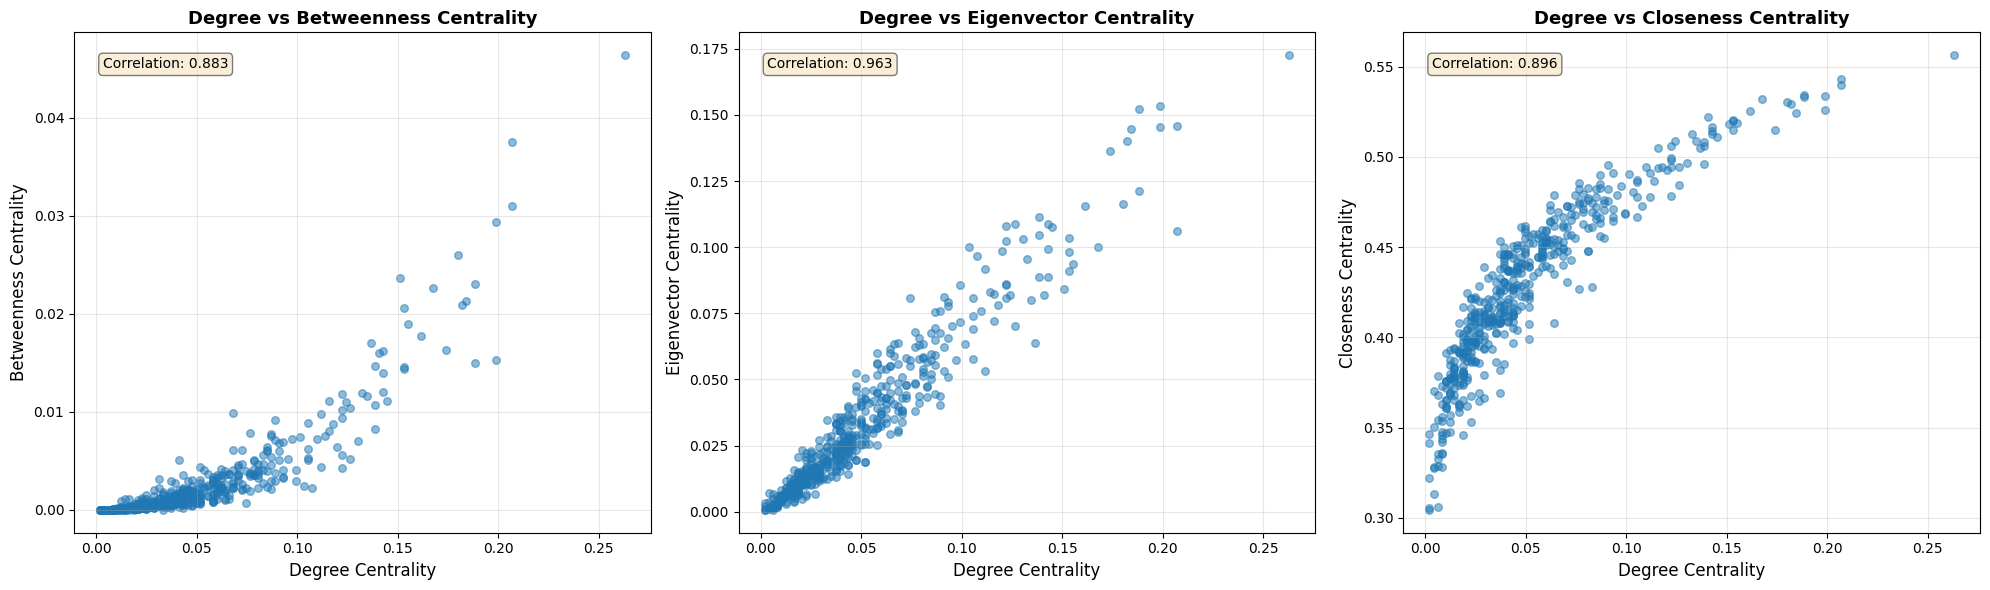

Correlation coefficients:
  Degree vs Betweenness: 0.883
  Degree vs Eigenvector: 0.963
  Degree vs Closeness: 0.896


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Degree vs Betweenness
axes[0].scatter(degree_values, betweenness_values, alpha=0.5, s=30)
axes[0].set_xlabel("Degree Centrality", fontsize=12)
axes[0].set_ylabel("Betweenness Centrality", fontsize=12)
axes[0].set_title("Degree vs Betweenness Centrality", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f"Correlation: {corr_db:.3f}", 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Degree vs Eigenvector
axes[1].scatter(degree_values, eigenvector_values, alpha=0.5, s=30)
axes[1].set_xlabel("Degree Centrality", fontsize=12)
axes[1].set_ylabel("Eigenvector Centrality", fontsize=12)
axes[1].set_title("Degree vs Eigenvector Centrality", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f"Correlation: {corr_de:.3f}", 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Degree vs Closeness
axes[2].scatter(degree_values, closeness_values, alpha=0.5, s=30)
axes[2].set_xlabel("Degree Centrality", fontsize=12)
axes[2].set_ylabel("Closeness Centrality", fontsize=12)
axes[2].set_title("Degree vs Closeness Centrality", fontsize=13, fontweight="bold")
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f"Correlation: {corr_dc:.3f}", 
             transform=axes[2].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Correlation coefficients:")
print(f"  Degree vs Betweenness: {corr_db:.3f}")
print(f"  Degree vs Eigenvector: {corr_de:.3f}")
print(f"  Degree vs Closeness: {corr_dc:.3f}")


> **Figure 5** shows scatter plots comparing different centrality measures, revealing strong correlations between measures ($r = 0.883$ for degree vs betweenness, $r = 0.963$ for degree vs eigenvector, $r = 0.896$ for degree vs closeness). These correlations indicate that highly connected nodes tend to serve multiple roles simultaneously.
>
> Having such high correlation between degree and eigenvector ($r = 0.963$) shows that nodes with many direct connections are almost always connected to other important nodes, creating influential neighborhoods around network hubs. This is reflected in the top rankings: Led Zeppelin ranks first across all measures, demonstrating its central role as both a hub (highest degree at $0.2629$), bridge between communities (highest betweenness at $0.0464$), prestigious node (highest eigenvector at $0.1726$), and well-positioned node (highest closeness at $0.5565$). Similarly, Queen (band), Bob Dylan, Deep Purple, and Metallica consistently appear in the top 5 across multiple measures.
>
> However, the strong but imperfect correlations reveal some specialization. The correlation between degree and betweenness ($r = 0.883$) is the lowest among the three, and the curvilinear relationship shows that some nodes with moderate degrees can have high betweenness. This pattern is evident in the rankings: Jimi Hendrix appears in the top 5 for betweenness ($0.0260$) but not for other measures, indicating specialized bridge nodes that connect different communities without necessarily having the highest degree. Similarly, David Bowie ranks high in closeness centrality ($0.5343$) but not in other measures, suggesting efficient positioning in the network structure without being the most connected hub.
>
> These findings reveal the nuanced nature of importance in the network: while hubs often serve multiple roles simultaneously, some nodes play specialized roles that highlight different aspects of network structure beyond simple connectivity.


## Assortativity: Mixing Patterns

Assortativity measures whether similar nodes connect to similar nodes (homophily) or dissimilar nodes (heterophily), revealing patterns in how the network organizes itself.


In [20]:
# Calculate degree assortativity
degree_assort = nx.degree_assortativity_coefficient(G_und)
print(f"Degree assortativity coefficient: {degree_assort:.4f}")

# Calculate attribute assortativity for content_length
# Using attribute_assortativity_coefficient as specified in the exercise hint
attribute_assort = nx.attribute_assortativity_coefficient(G_und, "content_length")
print(f"Attribute assortativity (content_length): {attribute_assort:.4f}")

Degree assortativity coefficient: 0.0088
Attribute assortativity (content_length): -0.0034


In [21]:
# interpretation
print("\nInterpretation:")
if abs(degree_assort) < 0.1:
    print(f"  Neutral degree assortativity ({degree_assort:.4f}) indicates random mixing by degree.")
    print("  The value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.")
elif degree_assort > 0:
    print(f"  Positive degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to high-degree nodes.")
else:
    print(f"  Negative degree assortativity ({degree_assort:.4f}) indicates that high-degree nodes tend to connect to low-degree nodes.")
    print("  This creates a hub-and-spoke structure.")

if abs(attribute_assort) < 0.05:
    print(f"  Weak attribute assortativity ({attribute_assort:.4f}) suggests content_length doesn't strongly influence connections.")
elif attribute_assort > 0:
    print(f"  Positive attribute assortativity ({attribute_assort:.4f}) indicates that nodes with similar content_length values tend to connect.")
    print("  This may reflect common editorial practices or similar levels of historical importance.")
else:
    print(f"  Negative attribute assortativity ({attribute_assort:.4f}) indicates that nodes with different content_length values tend to connect.")



Interpretation:
  Neutral degree assortativity (0.0088) indicates random mixing by degree.
  The value is close to zero, suggesting no strong tendency for similar-degree nodes to connect.
  Weak attribute assortativity (-0.0034) suggests content_length doesn't strongly influence connections.


**Degree assortativity**: The coefficient of $0.0088$ is close to zero, indicating nearly neutral mixing by degree in this network. This result shows that high-degree nodes (like Led Zeppelin) do not strongly prefer connecting to other high-degree nodes, nor do they prefer connecting to low-degree nodes. The network exhibits essentially random mixing by degree, meaning that well-connected bands are equally likely to link to well-connected or less-connected bands. This pattern differs from strong assortative networks (where hubs connect to hubs) or disassortative networks (where hubs connect to many low-degree nodes), suggesting that the Wikipedia rock performer network does not form distinct communities of well-connected bands, nor does it exhibit a hub-spoke structure.

**Attribute assortativity**: The coefficient for `content_length` is $-0.0034$, which is close to zero, indicating that bands with similar Wikipedia page lengths do not tend to connect preferentially. This finding suggests that editorial practices (whether a page is comprehensive or brief) do not strongly influence which bands are linked together. Bands with long Wikipedia pages are just as likely to link to bands with short pages as to other bands with long pages. This indicates that connection patterns in this network are not primarily driven by page comprehensiveness, but rather by other factors such as musical relationships, shared history, or collaborative connections.


## Weight Computation for Backbone Extraction

To extract network backbones, we assign weights to edges based on **edge betweenness centrality**, which measures how many shortest paths pass through each edge. We create three weighted network variants: (1) weights proportional to edge betweenness, normalized to [1, 100]; (2) weights proportional to the inverse of edge betweenness, normalized to [1, 100]; and (3) edge betweenness weights normalized to [0.01, 1.0] for High-Salience Skeleton. The results are presented below.


In [22]:
# edge betweenness centrality for the undirected Giant Connected Component
edge_betweenness = nx.edge_betweenness_centrality(G_gcc, normalized=True)

print(f"Computing edge betweenness for {G_gcc.number_of_edges()} edges...")
print("Done!")

Computing edge betweenness for 6019 edges...
Done!


In [23]:
# Weighted Network 1: weights = edge betweenness (normalized 1-100)
eb_values = list(edge_betweenness.values())
eb_min = min(eb_values)
eb_max = max(eb_values)

# Normalize to [1, 100]
if eb_max > eb_min:
    G_weighted1 = G_gcc.copy()
    for (u, v), weight in edge_betweenness.items():
        normalized_weight = 1 + 99 * (weight - eb_min) / (eb_max - eb_min)
        G_weighted1[u][v]['weight'] = normalized_weight
else:
    G_weighted1 = G_gcc.copy()
    for (u, v) in G_weighted1.edges():
        G_weighted1[u][v]['weight'] = 1

print(f"Weighted Network 1: Edge weights normalized from [{eb_min:.6f}, {eb_max:.6f}] to [1, 100]")

Weighted Network 1: Edge weights normalized from [0.000047, 0.004132] to [1, 100]


In [24]:
# Weighted Network 2: weights = 1 / (edge betweenness), normalized
G_weighted2 = G_gcc.copy()
eb_inverse_values = [1 / w if w > 0 else 0 for w in eb_values]
inv_min = min([v for v in eb_inverse_values if v > 0])
inv_max = max(eb_inverse_values)

if inv_max > inv_min:
    for (u, v), weight in edge_betweenness.items():
        if weight > 0:
            inv_weight = 1 / weight
            normalized_weight = 1 + 99 * (inv_weight - inv_min) / (inv_max - inv_min)
            G_weighted2[u][v]['weight'] = normalized_weight
        else:
            G_weighted2[u][v]['weight'] = 1
else:
    for (u, v) in G_weighted2.edges():
        G_weighted2[u][v]['weight'] = 1

print(f"Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]")


Weighted Network 2: Inverse edge betweenness, normalized to [1, 100]


In [25]:
# Weighted Network 3: For High-Salience Skeleton, we use edge betweenness as weights directly
# HSS uses distances = 1/weight, so higher betweenness = lower distance = more important paths
# We normalize to avoid zero weights but HSS doesn't need the [1,100] normalization
G_weighted3 = G_gcc.copy()
if eb_max > eb_min:
    for (u, v), weight in edge_betweenness.items():
        # Normalize to [0.01, 1.0] to avoid division by zero in HSS distance calculation
        normalized_weight = 0.01 + 0.99 * (weight - eb_min) / (eb_max - eb_min)
        G_weighted3[u][v]['weight'] = normalized_weight
else:
    for (u, v) in G_weighted3.edges():
        G_weighted3[u][v]['weight'] = 1.0

print(f"Weighted Network 3: Edge weights for High-Salience Skeleton (using edge betweenness)")
print(f"  Weights normalized from [{eb_min:.6f}, {eb_max:.6f}] to [0.01, 1.0] for distance calculation")


Weighted Network 3: Edge weights for High-Salience Skeleton (using edge betweenness)
  Weights normalized from [0.000047, 0.004132] to [0.01, 1.0] for distance calculation


## Network Backbone Extraction

We extract network backbones to simplify the network and reveal its core structure. For Networks 1 and 2, we implement the **Disparity Filter** to identify statistically significant edges based on whether edge weights are unlikely under a null hypothesis of random weight distribution. For Network 3, we use the **High-Salience Skeleton** method to identify edges important for shortest path structure. The results and interpretation are presented below.


In [26]:
def disparity_filter_impl(table, undirected=True):
    """
    Implement disparity filter to compute significance scores for edges.
    Returns table with columns: src, trg, nij, score
    """
    table = table.copy()
    # for each source node, calculate strength (sum of edge weights) and degree
    node_strength = table.groupby('src')['nij'].sum().reset_index()
    node_strength.columns = ['src', 'strength']
    node_degree = table.groupby('src')['trg'].count().reset_index()
    node_degree.columns = ['src', 'degree']
    
    # Merge with original table
    table = table.merge(node_strength, on='src', how='left')
    table = table.merge(node_degree, on='src', how='left')
    
    # Calculate disparity filter score
    # score = 1.0 - ((1.0 - (w_ij / s_i))^(k_i - 1))
    # Handle edge case where degree = 1 (avoid 0^0)
    mask_degree_gt_1 = table['degree'] > 1
    table['score'] = 0.0  # Default score
    # For nodes with degree > 1, calculate the score
    table.loc[mask_degree_gt_1, 'score'] = 1.0 - ((1.0 - (table.loc[mask_degree_gt_1, 'nij'] / table.loc[mask_degree_gt_1, 'strength'])) ** (table.loc[mask_degree_gt_1, 'degree'] - 1))
    
    # For undirected graphs, take maximum score for each edge pair
    if undirected:
        table['edge'] = table.apply(lambda x: "%s-%s" % (min(x['src'], x['trg']), max(x['src'], x['trg'])), axis=1)
        table_maxscore = table.groupby('edge')['score'].max().reset_index()
        table = table.merge(table_maxscore, on='edge', suffixes=('', '_max'))
        table['score'] = table['score_max']
        table = table.drop_duplicates(subset=['edge'])
        table = table.drop(['edge', 'score_max'], axis=1)
    
    return table[['src', 'trg', 'nij', 'score']]

The disparity filter computes significance scores using the formula: $score = 1.0 - ((1.0 - (w_{ij} / s_i))^{(k_i - 1)})$, where $w_{ij}$ is the edge weight, $s_i$ is the node strength (sum of edge weights), and $k_i$ is the node degree. Higher scores indicate edges that are statistically significant given the null hypothesis of random weight distribution. For undirected graphs, we use the maximum score for each edge pair.


In [27]:
def nx_to_backboning_table(G):
    edges = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1.0)
        edges.append({'src': u, 'trg': v, 'nij': weight})
    return pd.DataFrame(edges)

def backboning_table_to_nx(table):
    G = nx.Graph()
    for _, row in table.iterrows():
        G.add_edge(row['src'], row['trg'], weight=row['nij'])
    return G

In [28]:
table1 = nx_to_backboning_table(G_weighted1)
table2 = nx_to_backboning_table(G_weighted2)
table3 = nx_to_backboning_table(G_weighted3)


In [29]:
table1_scored = disparity_filter_impl(table1, undirected=True)
table2_scored = disparity_filter_impl(table2, undirected=True)


In [30]:
alpha_threshold = 0.85
backbone1_table = table1_scored[table1_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]
backbone2_table = table2_scored[table2_scored['score'] > alpha_threshold][['src', 'trg', 'nij']]

backbone1 = backboning_table_to_nx(backbone1_table)
backbone2 = backboning_table_to_nx(backbone2_table)

print(f"Backbone 1: {backbone1.number_of_nodes()} nodes, {backbone1.number_of_edges()} edges")
print(f"Backbone 2: {backbone2.number_of_nodes()} nodes, {backbone2.number_of_edges()} edges")


Backbone 1: 331 nodes, 344 edges
Backbone 2: 114 nodes, 110 edges


We apply the disparity filter to Networks 1 and 2 to compute significance scores, then filter edges with scores above the threshold (0.85). This retains only the most statistically significant edges, substantially reducing network density.


In [31]:
import sys
import os
if not os.path.exists(os.path.join(os.getcwd(), 'backboning.py')):
    assignment_parts_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'social-graphs', 'assignment-2-parts')
    if os.path.exists(os.path.join(assignment_parts_path, 'backboning.py')):
        sys.path.insert(0, assignment_parts_path)
    else:
        sys.path.insert(0, os.getcwd())
else:
    sys.path.insert(0, os.getcwd())

from backboning import high_salience_skeleton


In [32]:
table3_scored = high_salience_skeleton(table3, undirected=True, return_self_loops=False)
hss_threshold = np.percentile(table3_scored['score'], 80)
backbone3_table = table3_scored[table3_scored['score'] > hss_threshold][['src', 'trg', 'nij']]
backbone3 = backboning_table_to_nx(backbone3_table)
print(f"Backbone 3 (HSS): {backbone3.number_of_nodes()} nodes, {backbone3.number_of_edges()} edges")


Calculating HSS score...


Backbone 3 (HSS): 321 nodes, 1195 edges


For Network 3, we use the High-Salience Skeleton method which identifies edges critical for shortest path structure. We retain edges with scores above the 80th percentile, preserving the network's path-based topology while reducing complexity.


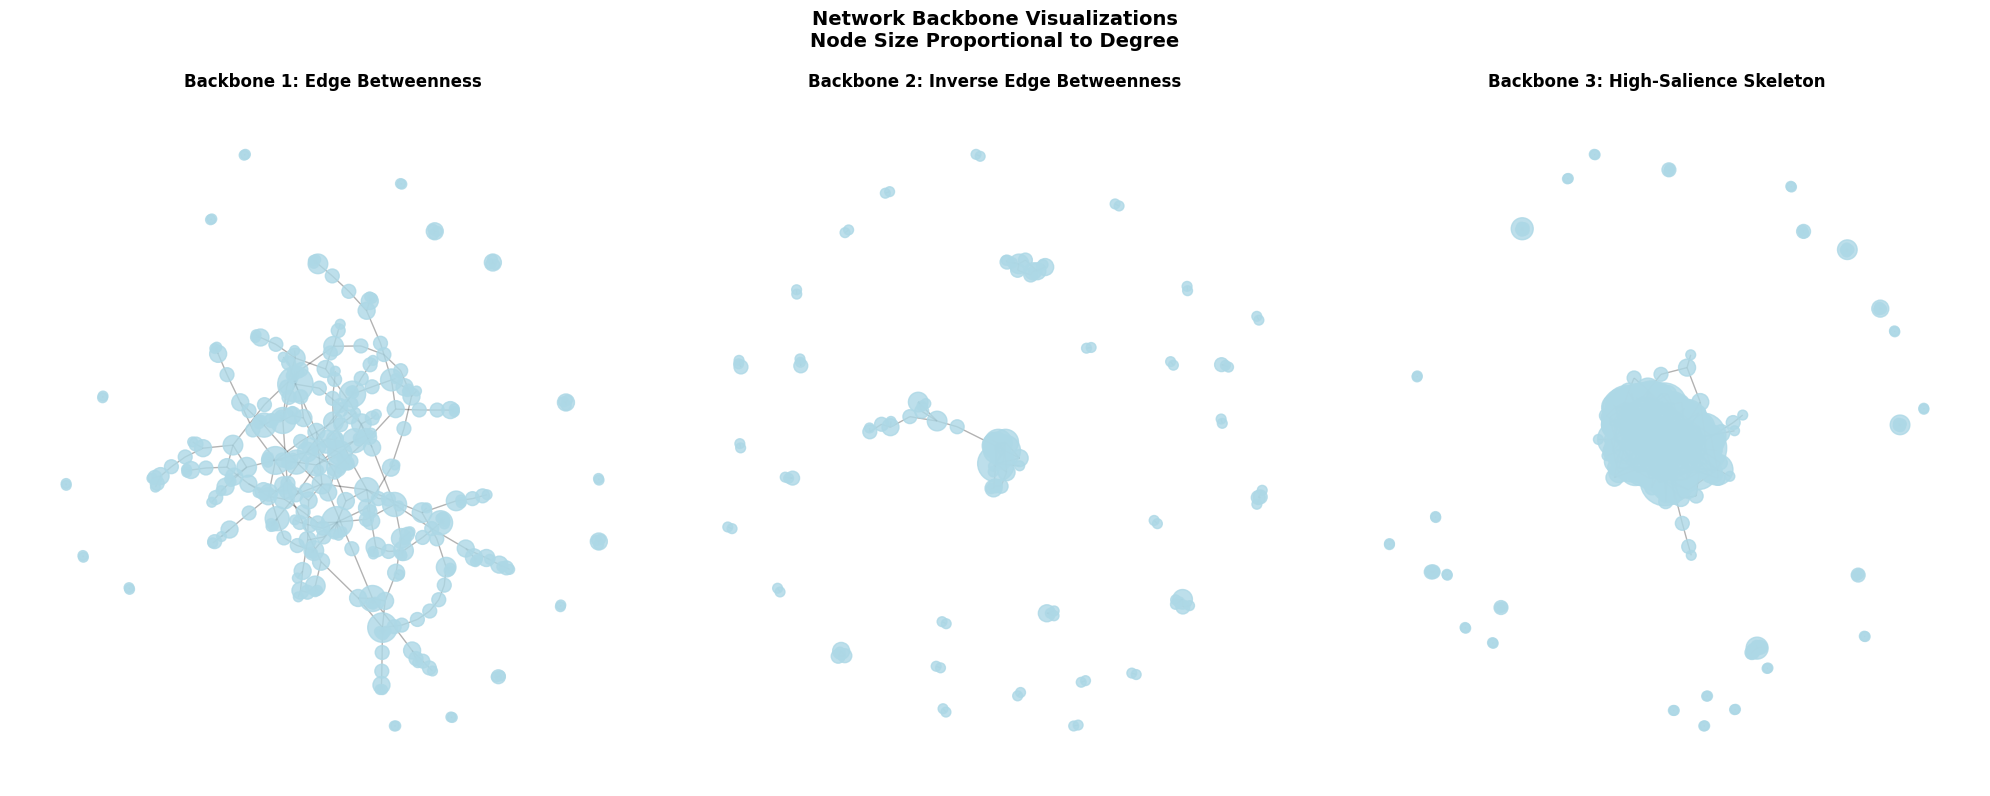

In [35]:
backbones = [
    (backbone1, "Backbone 1: Edge Betweenness"),
    (backbone2, "Backbone 2: Inverse Edge Betweenness"),
    (backbone3, "Backbone 3: High-Salience Skeleton")
]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (backbone, title) in enumerate(backbones):
    if backbone.number_of_nodes() == 0:
        axes[idx].text(0.5, 0.5, "Empty backbone", ha='center', va='center')
        axes[idx].set_title(title, fontsize=12, fontweight="bold")
        axes[idx].set_xlabel("X Position (ForceAtlas2 Layout)", fontsize=10)
        axes[idx].set_ylabel("Y Position (ForceAtlas2 Layout)", fontsize=10)
        continue
    
    pos_bb = nx.forceatlas2_layout(backbone, max_iter=100, seed=42)
    degrees_bb = dict(backbone.degree())
    node_sizes_bb = [degrees_bb[n] * 50 for n in backbone.nodes()]
    
    nx.draw_networkx_nodes(backbone, pos_bb, node_size=node_sizes_bb, node_color="lightblue", alpha=0.8, ax=axes[idx])
    nx.draw_networkx_edges(backbone, pos_bb, alpha=0.3, width=1.0, edge_color="black", ax=axes[idx])
    
    axes[idx].set_title(title, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("X Position (ForceAtlas2 Layout)", fontsize=10)
    axes[idx].set_ylabel("Y Position (ForceAtlas2 Layout)", fontsize=10)
    axes[idx].axis("off")

plt.suptitle("Network Backbone Visualizations\nNode Size Proportional to Degree", 
             fontsize=14, fontweight="bold", y=0.99)
plt.tight_layout()
plt.show()


> **Figure 9** shows three network backbone visualizations extracted using different methods. **Backbone 1** (344 edges) emphasizes high edge-betweenness edges, which are critical bridges connecting different communities. This backbone retains a moderately dense structure, preserving the main connectivity patterns while filtering out redundant connections. **Backbone 2** (110 edges) emphasizes low edge-betweenness edges, representing alternative paths and local connections within communities. This backbone is the sparsest, consisting mainly of small disconnected components, revealing the network's local connectivity structure. **Backbone 3** (1195 edges) uses the High-Salience Skeleton method, which identifies edges important for shortest path structure. This backbone maintains a dense structure that preserves the network's hierarchical organization and path-based topology.

The visual differences between backbones reveal distinct structural perspectives: Backbone 1 highlights main structural bridges that connect communities, Backbone 2 shows alternative paths and local connectivity patterns that differ from the main bridges, and Backbone 3 emphasizes shortest path structure that reveals hierarchical organization. Each backbone provides a complementary view of the network's core architecture, demonstrating how different filtering methods emphasize different types of relationships between bands.
